## Polar Sea Ice Prediction

## Initial Setup

In [122]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib.patches as mpatches
import time

# Classifier Libraries
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import collections


# Other Libraries
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from collections import Counter
from sklearn.model_selection import KFold, StratifiedKFold
import warnings
warnings.filterwarnings("ignore")


df = pd.read_csv('Arctic_domain_mean_monthly_1979_2018.csv')
df.head()

,wind_10m,specific_humidity,LW_down,SW_down,rainfall,snowfall,sosaline,sst,t2m,surface_pressure,sea_ice_extent
0,5.531398,0.811961,186.687054,3.127880,1.009872,0.892319,33.341556,273.355237,250.388101,984.633032,15604191
1,5.328020,0.688896,174.794571,18.541594,0.920831,0.781347,33.365164,273.121885,247.071202,983.980418,16378929
2,5.432511,0.916124,190.741933,67.690429,0.983327,0.855266,33.365938,273.088099,252.954138,985.140468,16521089
3,4.792836,1.272056,212.937925,156.223673,0.890723,0.705203,33.350408,273.126062,259.557456,989.314698,15561238
4,4.819028,2.239776,253.690478,230.950833,1.201308,0.688723,33.295768,273.393551,269.375118,984.483658,14085613


In [123]:
df.describe()

,wind_10m,specific_humidity,LW_down,SW_down,rainfall,snowfall,sosaline,sst,t2m,surface_pressure,sea_ice_extent
count,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,4.800000e+02
mean,5.161081,2.331158,242.219553,96.185238,1.382623,0.718565,33.257527,274.743387,264.836761,981.196167,1.169491e+07
std,0.441428,1.468723,44.023005,88.617732,0.332151,0.287729,0.106450,1.598909,10.627358,3.072038,3.188534e+06
min,4.249461,0.688896,174.794571,1.081732,0.794136,0.090444,33.028562,273.005160,247.071202,969.511282,3.629315e+06
25%,4.729818,1.028592,198.621402,14.307873,1.094230,0.519795,33.159154,273.422706,254.329179,979.207241,9.183172e+06
50%,5.236037,1.736932,236.223251,69.481335,1.350808,0.782740,33.276189,274.014402,264.236093,981.100326,1.233371e+07
75%,5.517833,3.639371,285.930901,167.683697,1.663058,0.943129,33.353202,276.026006,275.779139,983.128603,1.451544e+07
max,6.084062,5.287309,313.660402,252.105756,2.129987,1.224073,33.538621,279.000863,281.128579,990.897955,1.652109e+07


In [124]:
# Good No Null Values!
df.isnull().sum().max()

0

In [125]:
df.columns

Index(['wind_10m', 'specific_humidity', 'LW_down', 'SW_down', 'rainfall',
       'snowfall', 'sosaline', 'sst', 't2m', 'surface_pressure',
       'sea_ice_extent'],
      dtype='object')

## Shape

In [126]:

print("HEAD of df\n", df.head())
print("\nTAIL of df\n", df.tail())

# Shape of DataFrame
print("\nSHAPE of df\n", df.shape) 

HEAD of df
    wind_10m  specific_humidity     LW_down     SW_down  rainfall  snowfall  \
0  5.531398           0.811961  186.687054    3.127880  1.009872  0.892319   
1  5.328020           0.688896  174.794571   18.541594  0.920831  0.781347   
2  5.432511           0.916124  190.741933   67.690429  0.983327  0.855266   
3  4.792836           1.272056  212.937925  156.223673  0.890723  0.705203   
4  4.819028           2.239776  253.690478  230.950833  1.201308  0.688723   

    sosaline         sst         t2m  surface_pressure  sea_ice_extent  
0  33.341556  273.355237  250.388101        984.633032        15604191  
1  33.365164  273.121885  247.071202        983.980418        16378929  
2  33.365938  273.088099  252.954138        985.140468        16521089  
3  33.350408  273.126062  259.557456        989.314698        15561238  
4  33.295768  273.393551  269.375118        984.483658        14085613  

TAIL of df
      wind_10m  specific_humidity     LW_down     SW_down  rainfall  

## Check missing value

In [127]:
# Checks

# Check data types
print(df.info())

# Check for missing values
print('\n\nMissing Values\n',df.isnull().sum(axis=0))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 480 entries, 0 to 479
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   wind_10m           480 non-null    float64
 1   specific_humidity  480 non-null    float64
 2   LW_down            480 non-null    float64
 3   SW_down            480 non-null    float64
 4   rainfall           480 non-null    float64
 5   snowfall           480 non-null    float64
 6   sosaline           480 non-null    float64
 7   sst                480 non-null    float64
 8   t2m                480 non-null    float64
 9   surface_pressure   480 non-null    float64
 10  sea_ice_extent     480 non-null    int64  
dtypes: float64(10), int64(1)
memory usage: 41.4 KB
None


Missing Values
 wind_10m             0
specific_humidity    0
LW_down              0
SW_down              0
rainfall             0
snowfall             0
sosaline             0
sst                  0
t2m         

## Check Duplicates

In [128]:
# Check for duplicates
print('\n Duplicates\n',df.duplicated().sum())


 Duplicates
 0


##  Descriptive Statistics

In [129]:
# shows the statistical summary of numerical columns

df.describe()

,wind_10m,specific_humidity,LW_down,SW_down,rainfall,snowfall,sosaline,sst,t2m,surface_pressure,sea_ice_extent
count,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,4.800000e+02
mean,5.161081,2.331158,242.219553,96.185238,1.382623,0.718565,33.257527,274.743387,264.836761,981.196167,1.169491e+07
std,0.441428,1.468723,44.023005,88.617732,0.332151,0.287729,0.106450,1.598909,10.627358,3.072038,3.188534e+06
min,4.249461,0.688896,174.794571,1.081732,0.794136,0.090444,33.028562,273.005160,247.071202,969.511282,3.629315e+06
25%,4.729818,1.028592,198.621402,14.307873,1.094230,0.519795,33.159154,273.422706,254.329179,979.207241,9.183172e+06
50%,5.236037,1.736932,236.223251,69.481335,1.350808,0.782740,33.276189,274.014402,264.236093,981.100326,1.233371e+07
75%,5.517833,3.639371,285.930901,167.683697,1.663058,0.943129,33.353202,276.026006,275.779139,983.128603,1.451544e+07
max,6.084062,5.287309,313.660402,252.105756,2.129987,1.224073,33.538621,279.000863,281.128579,990.897955,1.652109e+07


In [130]:
# Univariate descriptive statistics using pandas

# Ensure the maximum number of columns are displayed in pandas
pd.set_option('display.max_columns', None)

# Univariate numerical statistics using pandas .describe 
print("UNIVARIATE DESCRIPTIVE STAT using pandas\n",df.describe(include='all').T)

UNIVARIATE DESCRIPTIVE STAT using pandas
                    count          mean           std           min  \
wind_10m           480.0  5.161081e+00  4.414280e-01  4.249461e+00   
specific_humidity  480.0  2.331158e+00  1.468723e+00  6.888964e-01   
LW_down            480.0  2.422196e+02  4.402301e+01  1.747946e+02   
SW_down            480.0  9.618524e+01  8.861773e+01  1.081732e+00   
rainfall           480.0  1.382623e+00  3.321512e-01  7.941362e-01   
snowfall           480.0  7.185651e-01  2.877292e-01  9.044425e-02   
sosaline           480.0  3.325753e+01  1.064497e-01  3.302856e+01   
sst                480.0  2.747434e+02  1.598909e+00  2.730052e+02   
t2m                480.0  2.648368e+02  1.062736e+01  2.470712e+02   
surface_pressure   480.0  9.811962e+02  3.072038e+00  9.695113e+02   
sea_ice_extent     480.0  1.169491e+07  3.188534e+06  3.629315e+06   

                            25%           50%           75%           max  
wind_10m           4.729818e+00  5.236037

In [131]:
print("\n SKEWNESS\n",df.skew())
print("\n KURTOSIS\n",df.kurt())


 SKEWNESS
 wind_10m            -0.216541
specific_humidity    0.674272
LW_down              0.228035
SW_down              0.448774
rainfall             0.306716
snowfall            -0.508041
sosaline            -0.250144
sst                  0.864297
t2m                  0.096892
surface_pressure     0.042099
sea_ice_extent      -0.473712
dtype: float64

 KURTOSIS
 wind_10m            -1.118349
specific_humidity   -1.047676
LW_down             -1.468790
SW_down             -1.347130
rainfall            -1.129708
snowfall            -0.886573
sosaline            -1.047016
sst                 -0.538676
t2m                 -1.526394
surface_pressure     0.484643
sea_ice_extent      -0.919816
dtype: float64


## Loading Combined Data 1979- 2018
## EDA
Features:
'wind_10m', 'specific_humidity', 'LW_down', 'SW_down', 'rainfall', 'snowfall', 'sosaline', 'sst', 't2m', 'surface_pressure','sea_ice_extent'




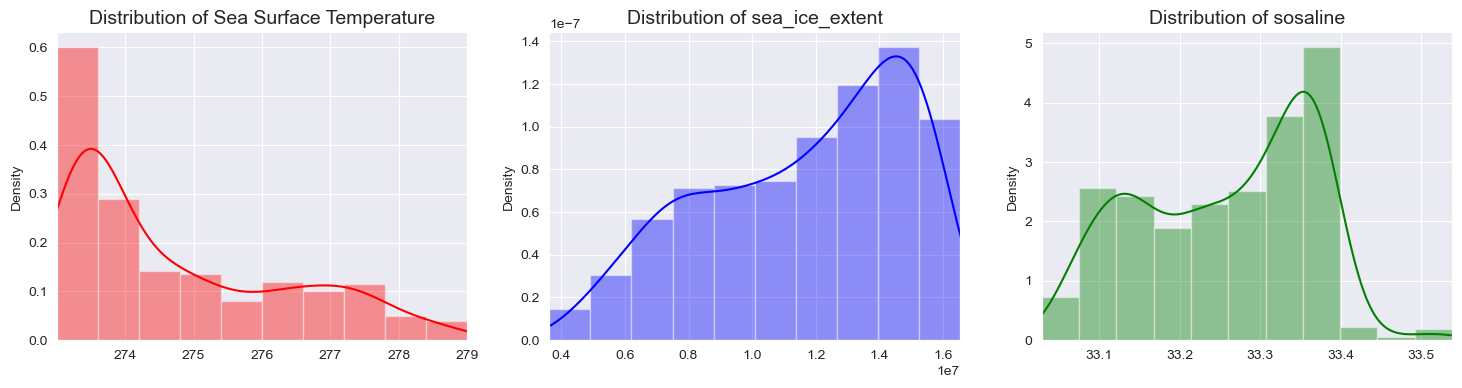

In [132]:
fig, ax = plt.subplots(1, 3, figsize=(18,4))

amount_val = df['sst'].values
time_val = df['sea_ice_extent'].values
time_val2 = df['sosaline'].values

sns.distplot(amount_val, ax=ax[0], color='r')
ax[0].set_title('Distribution of Sea Surface Temperature', fontsize=14)
ax[0].set_xlim([min(amount_val), max(amount_val)])

sns.distplot(time_val, ax=ax[1], color='b')
ax[1].set_title('Distribution of sea_ice_extent', fontsize=14)
ax[1].set_xlim([min(time_val), max(time_val)])

sns.distplot(time_val2, ax=ax[2], color='g')
ax[2].set_title('Distribution of sosaline', fontsize=14)
ax[2].set_xlim([min(time_val2), max(time_val2)])



plt.show()

In [133]:
# Multivariate numerical descriptive statistics

#Correlation Matrix
print("CORRELATION MATRIX\n",df.corr())
print("\n\n")

CORRELATION MATRIX
                    wind_10m  specific_humidity   LW_down   SW_down  rainfall  \
wind_10m           1.000000          -0.835584 -0.834816 -0.858528 -0.409651   
specific_humidity -0.835584           1.000000  0.976903  0.664689  0.804001   
LW_down           -0.834816           0.976903  1.000000  0.701597  0.798024   
SW_down           -0.858528           0.664689  0.701597  1.000000  0.184473   
rainfall          -0.409651           0.804001  0.798024  0.184473  1.000000   
snowfall           0.906996          -0.883846 -0.821569 -0.768139 -0.476136   
sosaline           0.493132          -0.792022 -0.806095 -0.219732 -0.902897   
sst               -0.534729           0.853090  0.835272  0.243978  0.919866   
t2m               -0.847057           0.959348  0.995123  0.748010  0.755841   
surface_pressure  -0.283514          -0.063110 -0.021462  0.295678 -0.420548   
sea_ice_extent     0.362987          -0.709564 -0.743595 -0.088314 -0.912189   

                   

In [134]:
df.corr()

,wind_10m,specific_humidity,LW_down,SW_down,rainfall,snowfall,sosaline,sst,t2m,surface_pressure,sea_ice_extent
wind_10m,1.000000,-0.835584,-0.834816,-0.858528,-0.409651,0.906996,0.493132,-0.534729,-0.847057,-0.283514,0.362987
specific_humidity,-0.835584,1.000000,0.976903,0.664689,0.804001,-0.883846,-0.792022,0.853090,0.959348,-0.063110,-0.709564
LW_down,-0.834816,0.976903,1.000000,0.701597,0.798024,-0.821569,-0.806095,0.835272,0.995123,-0.021462,-0.743595
SW_down,-0.858528,0.664689,0.701597,1.000000,0.184473,-0.768139,-0.219732,0.243978,0.748010,0.295678,-0.088314
rainfall,-0.409651,0.804001,0.798024,0.184473,1.000000,-0.476136,-0.902897,0.919866,0.755841,-0.420548,-0.912189
snowfall,0.906996,-0.883846,-0.821569,-0.768139,-0.476136,1.000000,0.511990,-0.622828,-0.814920,-0.185542,0.387589
sosaline,0.493132,-0.792022,-0.806095,-0.219732,-0.902897,0.511990,1.000000,-0.906430,-0.771477,0.217150,0.915736
sst,-0.534729,0.853090,0.835272,0.243978,0.919866,-0.622828,-0.906430,1.000000,0.796540,-0.199531,-0.937285
t2m,-0.847057,0.959348,0.995123,0.748010,0.755841,-0.814920,-0.771477,0.796540,1.000000,0.014490,-0.708995
surface_pressure,-0.283514,-0.063110,-0.021462,0.295678,-0.420548,-0.185542,0.217150,-0.199531,0.014490,1.000000,0.245381


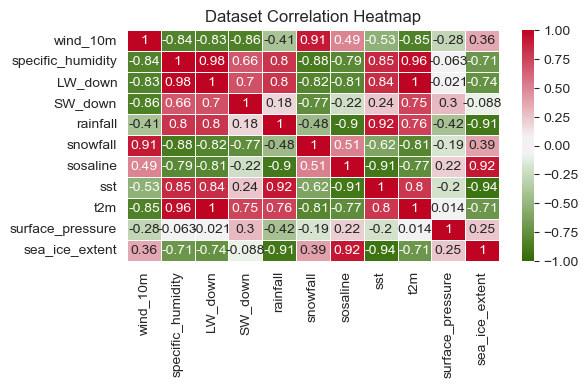

In [135]:
#Correlation Matrix as a Heatmap
sns.set_style('darkgrid')
plt.figure(figsize = (6,3))
cmap = sns.diverging_palette(120, 10, l = 40, s = 99, sep = 20, center = 'light', as_cmap = True) 
sns.heatmap((df).corr(), vmin = -1, vmax = 1, annot = True, cmap = cmap, lw = .5, linecolor = 'white')
plt.title("Dataset Correlation Heatmap")
plt.show()

In [136]:
# Covariance Matrix
print("\n\nCOVARIANCE MATRIX\n",df.cov())
print("\n\n")



COVARIANCE MATRIX
                         wind_10m  specific_humidity       LW_down  \
wind_10m                0.194859      -5.417384e-01 -1.622297e+01   
specific_humidity      -0.541738       2.157148e+00  6.316418e+01   
LW_down               -16.222967       6.316418e+01  1.938025e+03   
SW_down               -33.584212       8.651252e+01  2.737085e+03   
rainfall               -0.060063       3.922223e-01  1.166894e+01   
snowfall                0.115199      -3.735087e-01 -1.040657e+01   
sosaline                0.023172      -1.238288e-01 -3.777553e+00   
sst                    -0.377413       2.003358e+00  5.879378e+01   
t2m                    -3.973724       1.497412e+01  4.655664e+02   
surface_pressure       -0.384469      -2.847525e-01 -2.902486e+00   
sea_ice_extent     510907.778443      -3.322940e+06 -1.043776e+08   

                        SW_down       rainfall       snowfall       sosaline  \
wind_10m          -3.358421e+01      -0.060063       0.115199       0.

In [137]:
df.cov()

,wind_10m,specific_humidity,LW_down,SW_down,rainfall,snowfall,sosaline,sst,t2m,surface_pressure,sea_ice_extent
wind_10m,0.194859,-5.417384e-01,-1.622297e+01,-3.358421e+01,-0.060063,0.115199,0.023172,-3.774132e-01,-3.973724e+00,-3.844688e-01,5.109078e+05
specific_humidity,-0.541738,2.157148e+00,6.316418e+01,8.651252e+01,0.392222,-0.373509,-0.123829,2.003358e+00,1.497412e+01,-2.847525e-01,-3.322940e+06
LW_down,-16.222967,6.316418e+01,1.938025e+03,2.737085e+03,11.668942,-10.406566,-3.777553,5.879378e+01,4.655664e+02,-2.902486e+00,-1.043776e+08
SW_down,-33.584212,8.651252e+01,2.737085e+03,7.853102e+03,5.429864,-19.585927,-2.072806,3.456971e+01,7.044548e+02,8.049449e+01,-2.495417e+07
rainfall,-0.060063,3.922223e-01,1.166894e+01,5.429864e+00,0.110324,-0.045504,-0.031924,4.885217e-01,2.668035e+00,-4.291189e-01,-9.660772e+05
snowfall,0.115199,-3.735087e-01,-1.040657e+01,-1.958593e+01,-0.045504,0.082788,0.015682,-2.865339e-01,-2.491862e+00,-1.640035e-01,3.555876e+05
sosaline,0.023172,-1.238288e-01,-3.777553e+00,-2.072806e+00,-0.031924,0.015682,0.011332,-1.542774e-01,-8.727560e-01,7.101189e-02,3.108177e+05
sst,-0.377413,2.003358e+00,5.879378e+01,3.456971e+01,0.488522,-0.286534,-0.154277,2.556509e+00,1.353495e+01,-9.800805e-01,-4.778443e+06
t2m,-3.973724,1.497412e+01,4.655664e+02,7.044548e+02,2.668035,-2.491862,-0.872756,1.353495e+01,1.129407e+02,4.730790e-01,-2.402478e+07
surface_pressure,-0.384469,-2.847525e-01,-2.902486e+00,8.049449e+01,-0.429119,-0.164003,0.071012,-9.800805e-01,4.730790e-01,9.437418e+00,2.403575e+06


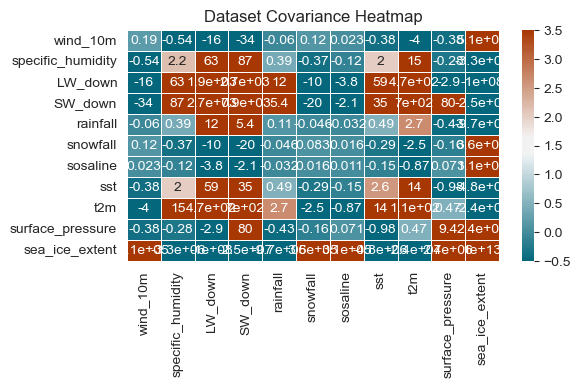

In [138]:
#Covariance Matrix as a Heatmap
sns.set_style('darkgrid')
plt.figure(figsize = (6,3))
cmap = sns.diverging_palette(220, 20, l = 40, s = 99, sep = 20, center = 'light', as_cmap = True) 
sns.heatmap((df).cov(), vmin = -0.5, vmax = 3.5, annot = True, cmap = cmap, lw = .5, linecolor = 'white')
plt.title("Dataset Covariance Heatmap")
plt.show()

## Separate features (X) and target (y)

In [139]:
# Separate features (X) and target (y)
X = df.iloc[:, :-1]  # All columns except the last one
y = df.iloc[:, -1]   # Last column as target

# Split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)  # Adjust test_size as needed

# Optionally, if you want to verify the shapes of your sets
print("Train set shape:", X_train.shape, y_train.shape)
print("Test set shape:", X_test.shape, y_test.shape)

Train set shape: (384, 10) (384,)
Test set shape: (96, 10) (96,)


In [140]:
X_train

,wind_10m,specific_humidity,LW_down,SW_down,rainfall,snowfall,sosaline,sst,t2m,surface_pressure
132,5.384420,0.889415,187.954846,3.191348,1.063483,0.803061,33.372654,273.344373,250.009300,979.072751
228,5.585006,0.825363,185.793814,3.298627,1.002288,0.796849,33.331376,273.474436,250.284147,985.939626
473,4.637448,4.068189,294.331476,244.788268,1.525216,0.342318,33.375188,275.294946,278.020243,980.223130
42,4.595061,4.913375,306.313992,209.228146,1.687148,0.235147,33.164609,275.944681,279.923464,980.295981
360,5.823613,0.964216,195.293738,3.325135,1.143058,0.882076,33.346914,273.624518,253.088991,978.908787
...,...,...,...,...,...,...,...,...,...,...
106,5.460995,1.161459,206.706642,5.191822,1.222999,0.956600,33.262897,274.179079,255.310920,982.270624
270,4.506077,5.093406,309.625066,204.644550,1.795353,0.206707,33.185396,276.708619,280.457985,980.607642
348,5.691847,0.923627,192.531247,3.090660,1.191424,0.969270,33.341692,273.651781,251.908193,979.020673
435,5.179858,1.567685,227.945943,153.724691,1.027518,0.756616,33.327232,273.417005,263.017651,981.183245


## Model prediction

Linear Regression:
Train R^2 score: 0.9804839498999987
Test R^2 score: 0.9804929700263795
Train MSE: 200353936017.3967
Test MSE: 185097020558.62418

Logistic Regression:
Train R^2 score: 0.12760416666666666
Test R^2 score: 0.0
Random Forest:
Train R^2 score: 0.9974084950614152
Test R^2 score: 0.9848787470868158
Train MSE: 26604677278.111603
Test MSE: 143481548197.17703

XGBoost:
Train R^2 score: 0.9999985363073456
Test R^2 score: 0.9695380950808778
Train MSE: 15026431.215494791
Test MSE: 289044916047.9297

Neural Network:
Train R^2 score: -0.4124509210729481
Test R^2 score: -0.25548835597704134
Train MSE: 14500377895030.227
Test MSE: 11912995179258.648



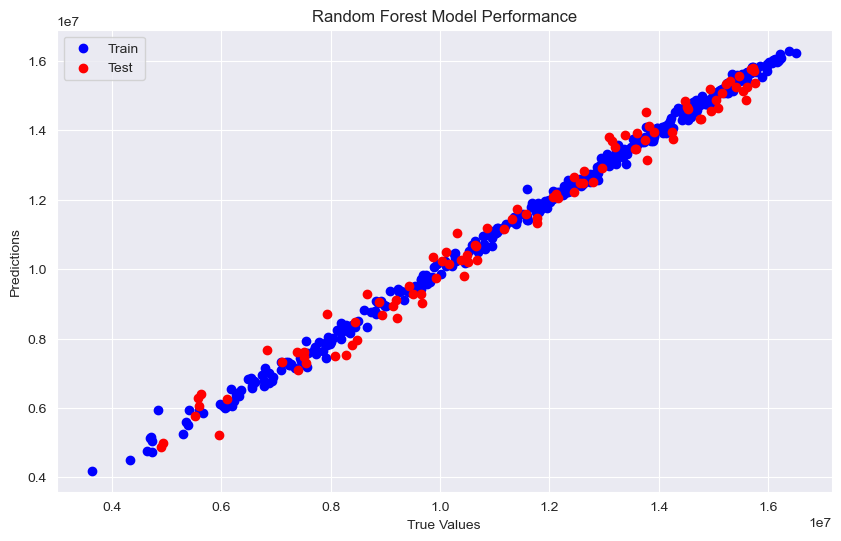

In [141]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.neural_network import MLPRegressor
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
# Models
models = {
    'Linear Regression': LinearRegression(),
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestRegressor(),
    'XGBoost': xgb.XGBRegressor(),
    'Neural Network': MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=500)
}

# Train and evaluate models
for name, model in models.items():
    model.fit(X_train, y_train)
    train_score = model.score(X_train, y_train)
    test_score = model.score(X_test, y_test)
    print(f"{name}:")
    print("Train R^2 score:", train_score)
    print("Test R^2 score:", test_score)
    if name != 'Logistic Regression':
        y_pred_train = model.predict(X_train)
        y_pred_test = model.predict(X_test)
        mse_train = mean_squared_error(y_train, y_pred_train)
        mse_test = mean_squared_error(y_test, y_pred_test)
        print("Train MSE:", mse_train)
        print("Test MSE:", mse_test)
        print()

# Visualize the results for Random Forest only
model = models['Random Forest']
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

plt.figure(figsize=(10, 6))

plt.scatter(y_train, y_pred_train, color='blue', label='Train')
plt.scatter(y_test, y_pred_test, color='red', label='Test')

plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('Random Forest Model Performance')
plt.legend()
plt.grid(True)

plt.show()


| Model             | Train R^2 Score | Test R^2 Score | Train MSE       | Test MSE         |
|-------------------|-----------------|----------------|-----------------|------------------|
| Linear Regression | 0.9805          | 0.9805         | 200,353,936,017| 185,097,020,559  |
| Logistic Regression | 0.1276        | 0.0            | N/A             | N/A              |
| Random Forest     | 0.9977          | 0.9843         | 23,226,225,377  | 148,891,247,286  |
| XGBoost           | 0.9999          | 0.9695         | 15,026,431      | 289,044,916,048  |
| Neural Network    | -2.0165         | -1.6869        | 30,967,823,127  | 25,495,409,643   |


## Calculate the feature importance
## XGBoost

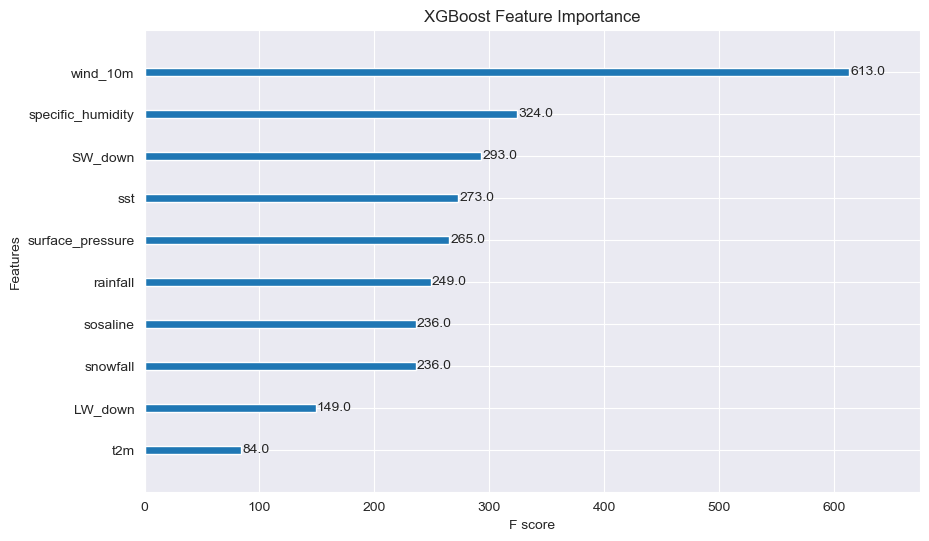

In [142]:
import xgboost as xgb

# Train the XGBoost model
model_xgb = xgb.XGBRegressor()
model_xgb.fit(X_train, y_train)

# Plot feature importance for XGBoost
plt.figure(figsize=(10, 6))
xgb.plot_importance(model_xgb, ax=plt.gca())
plt.title('XGBoost Feature Importance')
plt.show()


### Random Forest

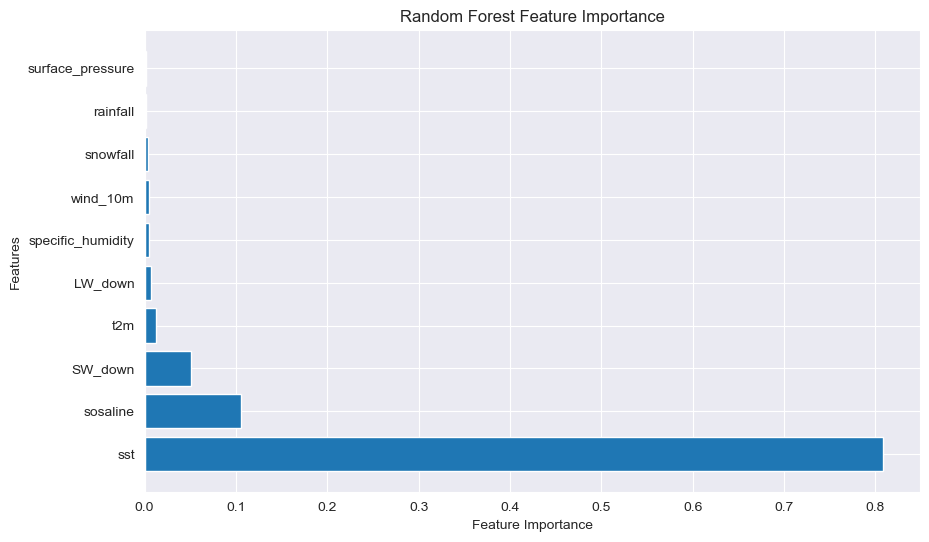

In [143]:
from sklearn.ensemble import RandomForestRegressor

# Train the Random Forest model
model_rf = RandomForestRegressor()
model_rf.fit(X_train, y_train)

# Plot feature importance for Random Forest
plt.figure(figsize=(10, 6))
importances_rf = model_rf.feature_importances_
indices_rf = np.argsort(importances_rf)[::-1]
plt.barh(X.columns[indices_rf], importances_rf[indices_rf])
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Random Forest Feature Importance')
plt.show()


### XAI Explaination

In [144]:
!pip install pdpbox shap lime



[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


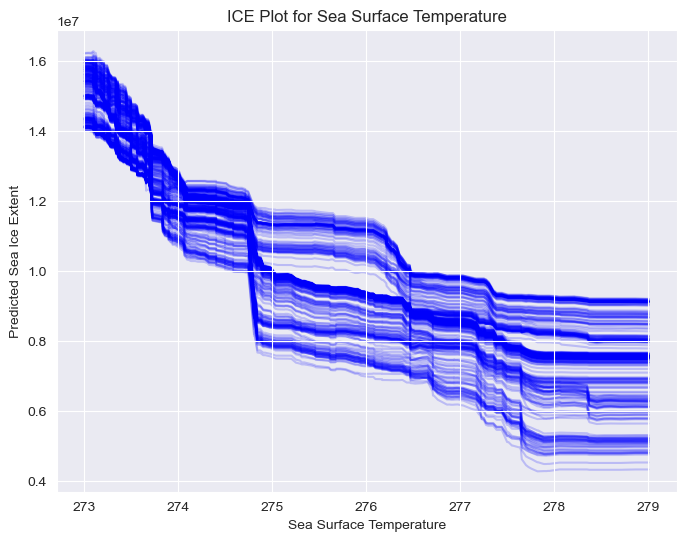

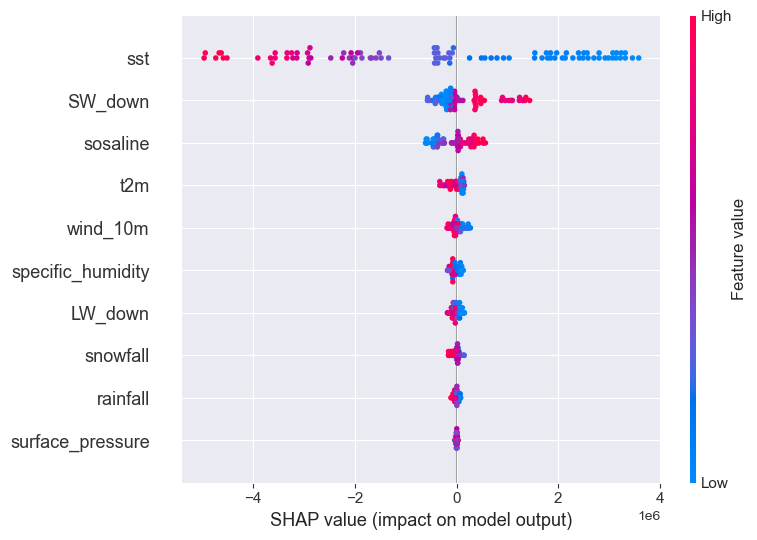

In [145]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import shap
import lime
import lime.lime_tabular
from pycebox.ice import ice, ice_plot

# Load the dataset
df = pd.read_csv('Arctic_domain_mean_monthly_1979_2018.csv')

# Separate features (X) and target (y)
X = df.drop(columns=['sea_ice_extent'])  # All columns except 'sea_ice_extent'
y = df['sea_ice_extent']  # Target column 'sea_ice_extent'

# Split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a RandomForestRegressor model
model_rf = RandomForestRegressor()
model_rf.fit(X_train, y_train)

# ICE Plot (Individual Conditional Expectation) for the 'wind_10m' feature
fig, ax = plt.subplots(figsize=(8, 6))
ice_data = ice(X_train, 'sst', model_rf.predict)
ice_plot(ice_data, c='blue', alpha=0.2, ax=ax)
plt.xlabel('Sea Surface Temperature')
plt.ylabel('Predicted Sea Ice Extent')
plt.title('ICE Plot for Sea Surface Temperature')
plt.show()

# SHAP (SHapley Additive exPlanations)
explainer = shap.Explainer(model_rf, X_train)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)

# LIME (Local Interpretable Model-agnostic Explanations)
explainer_lime = lime.lime_tabular.LimeTabularExplainer(X_train.values, feature_names=X_train.columns, mode='regression')
instance_idx = np.random.randint(0, len(X_test))
instance = X_test.iloc[[instance_idx]]
lime_exp = explainer_lime.explain_instance(instance.values[0], model_rf.predict)
lime_exp.show_in_notebook(show_table=True)


In [146]:
!pip install pycebox


[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


## Calculate the carbon

In [147]:
!pip install codecarbon



[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


## Code Carbon Emission for XGBoost

In [148]:
from codecarbon import EmissionsTracker
# Train the XGBoost model
model_xgb = xgb.XGBRegressor()

tracker = EmissionsTracker()
tracker.start()

model_xgb.fit(X_train, y_train)
emissions: float = tracker.stop()
print(emissions)

[codecarbon INFO @ 15:09:14] [setup] RAM Tracking...
[codecarbon INFO @ 15:09:14] [setup] GPU Tracking...
[codecarbon INFO @ 15:09:15] No GPU found.
[codecarbon INFO @ 15:09:15] [setup] CPU Tracking...
[codecarbon WARNING @ 15:09:15] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 15:09:15] CPU Model on constant consumption mode: Apple M1 Pro
[codecarbon INFO @ 15:09:15] >>> Tracker's metadata:
[codecarbon INFO @ 15:09:15]   Platform system: macOS-13.0.1-arm64-arm-64bit
[codecarbon INFO @ 15:09:15]   Python version: 3.10.8
[codecarbon INFO @ 15:09:15]   CodeCarbon version: 2.3.5
[codecarbon INFO @ 15:09:15]   Available RAM : 16.000 GB
[codecarbon INFO @ 15:09:15]   CPU count: 8
[codecarbon INFO @ 15:09:15]   CPU model: Apple M1 Pro
[codecarbon INFO @ 15:09:15]   GPU count: None
[codecarbon INFO @ 15:09:15]   GPU model: None
[codecarbon INFO @ 15:09:18] Energy consumed for RAM : 0.000001 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 15:09:18] Energy consume

2.0402813709856554e-07


## Code Carbon Emission for Random Forest

In [149]:
model_rf = RandomForestRegressor()


tracker = EmissionsTracker()
tracker.start()
model_rf.fit(X_train, y_train)
emissions: float = tracker.stop()
print(emissions)

[codecarbon INFO @ 15:09:18] [setup] RAM Tracking...
[codecarbon INFO @ 15:09:18] [setup] GPU Tracking...
[codecarbon INFO @ 15:09:18] No GPU found.
[codecarbon INFO @ 15:09:18] [setup] CPU Tracking...
[codecarbon WARNING @ 15:09:18] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 15:09:18] CPU Model on constant consumption mode: Apple M1 Pro
[codecarbon INFO @ 15:09:18] >>> Tracker's metadata:
[codecarbon INFO @ 15:09:18]   Platform system: macOS-13.0.1-arm64-arm-64bit
[codecarbon INFO @ 15:09:18]   Python version: 3.10.8
[codecarbon INFO @ 15:09:18]   CodeCarbon version: 2.3.5
[codecarbon INFO @ 15:09:18]   Available RAM : 16.000 GB
[codecarbon INFO @ 15:09:18]   CPU count: 8
[codecarbon INFO @ 15:09:18]   CPU model: Apple M1 Pro
[codecarbon INFO @ 15:09:18]   GPU count: None
[codecarbon INFO @ 15:09:18]   GPU model: None
[codecarbon INFO @ 15:09:20] Energy consumed for RAM : 0.000000 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 15:09:20] Energy consume

7.892064381301273e-08


## Code Carbon Emission for XAI explaination
### SHAP (Carbon Emission)

In [150]:

tracker = EmissionsTracker()
tracker.start()
explainer = shap.Explainer(model_rf, X_train)
emissions: float = tracker.stop()
print(emissions)

[codecarbon INFO @ 15:09:20] [setup] RAM Tracking...
[codecarbon INFO @ 15:09:20] [setup] GPU Tracking...
[codecarbon INFO @ 15:09:20] No GPU found.
[codecarbon INFO @ 15:09:20] [setup] CPU Tracking...
[codecarbon WARNING @ 15:09:20] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 15:09:20] CPU Model on constant consumption mode: Apple M1 Pro
[codecarbon INFO @ 15:09:20] >>> Tracker's metadata:
[codecarbon INFO @ 15:09:20]   Platform system: macOS-13.0.1-arm64-arm-64bit
[codecarbon INFO @ 15:09:20]   Python version: 3.10.8
[codecarbon INFO @ 15:09:20]   CodeCarbon version: 2.3.5
[codecarbon INFO @ 15:09:20]   Available RAM : 16.000 GB
[codecarbon INFO @ 15:09:20]   CPU count: 8
[codecarbon INFO @ 15:09:20]   CPU model: Apple M1 Pro
[codecarbon INFO @ 15:09:20]   GPU count: None
[codecarbon INFO @ 15:09:20]   GPU model: None
[codecarbon INFO @ 15:09:20] Energy consumed for RAM : 0.000000 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 15:09:20] Energy consume

6.31739131919024e-09


### LIME (Carbon Emission)

In [151]:
tracker = EmissionsTracker()
tracker.start()
lime_exp = explainer_lime.explain_instance(instance.values[0], model_rf.predict)
emissions: float = tracker.stop()
print(emissions)

[codecarbon INFO @ 15:09:20] [setup] RAM Tracking...
[codecarbon INFO @ 15:09:20] [setup] GPU Tracking...
[codecarbon INFO @ 15:09:20] No GPU found.
[codecarbon INFO @ 15:09:20] [setup] CPU Tracking...
[codecarbon WARNING @ 15:09:20] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 15:09:20] CPU Model on constant consumption mode: Apple M1 Pro
[codecarbon INFO @ 15:09:20] >>> Tracker's metadata:
[codecarbon INFO @ 15:09:20]   Platform system: macOS-13.0.1-arm64-arm-64bit
[codecarbon INFO @ 15:09:20]   Python version: 3.10.8
[codecarbon INFO @ 15:09:20]   CodeCarbon version: 2.3.5
[codecarbon INFO @ 15:09:20]   Available RAM : 16.000 GB
[codecarbon INFO @ 15:09:20]   CPU count: 8
[codecarbon INFO @ 15:09:20]   CPU model: Apple M1 Pro
[codecarbon INFO @ 15:09:20]   GPU count: None
[codecarbon INFO @ 15:09:20]   GPU model: None
[codecarbon INFO @ 15:09:20] Energy consumed for RAM : 0.000000 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 15:09:20] Energy consume

3.2862791877283846e-08
